In [8]:
# Тюнинг
import optuna as opt
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score
from sklearn.feature_selection import RFE

# Пайплайн
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin, BaseEstimator
from helpers.data import DataPreprocessor, CAT_FEATURES
from helpers.validation import valid_predictions

# Данные
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from imblearn.over_sampling import RandomOverSampler

%matplotlib inline

In [3]:
# Пути
ROOT = os.getcwd()
TRAIN_DATASET = os.path.join(ROOT, '../data/train_AIC.csv')
BALANCED_DATASET = os.path.join(ROOT, '../data/balanced_train.csv')
TEST_DATASET = os.path.join(ROOT, '../data/test_AIC.csv')
SUBMISSION_PATH = os.path.join(ROOT, '../submissions/')

def save_submission(model, subname):
    subname = os.path.join(SUBMISSION_PATH, f'{subname}.csv')
    preds = model.predict(test_df)
    submit_df = pd.DataFrame({'id': test_df.index, 'value': preds})
    submit_df.to_csv(subname, index=False)

# Загрузка датасетов
train_df = pd.read_csv(TRAIN_DATASET)
train_df = train_df.drop_duplicates()
test_df = pd.read_csv(TEST_DATASET)

X, y = train_df.iloc[:, :-1], train_df.iloc[:, -1]   
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

# Нормализация для кв/тестов
X_train = pd.concat([X_train, y_train], axis=1)

X_train = X_train[X_train['Длительность'] < 400]
X_train = X_train[(X_train['Сумма'] > 2) & (X_train['Сумма'] < 10)]
X_train = X_train[X_train['До поставки'] < 300]
X_train = X_train[X_train['Дней между 0_1'] < 400]
X_train = X_train[X_train['Количество изменений после согласований'] < 2000]
X_train = X_train[X_train['Количество'] < 300000]

y_train = X_train['y']
X_train = X_train.drop('y', axis=1)

X_general, y_general = train_df.iloc[:, :-1], train_df.iloc[:, -1]

In [9]:
# Функция оптимизации
def objective(trial: opt.Trial):
    # Параметры
    learning_rate = trial.suggest_float('learning_rate', 0.1, 1)
    iterations = trial.suggest_int('iterations', 300, 1000)
    max_depth = trial.suggest_int('max_depth', 4, 12)
    reg_lambda = trial.suggest_float('l2_leaf_reg', 0.1, 1)

    # Модель
    data_preprocessor = DataPreprocessor()
    model = CatBoostClassifier(
        cat_features=cat_features,
        learning_rate=learning_rate,
        iterations=iterations,
        max_depth=max_depth,
        reg_lambda=reg_lambda,
        # auto_class_weights='Balanced'
    )

    pipeline = Pipeline([
        ('data_preproc', data_preprocessor),
        ('model', model)
    ])
    
    cv_score = cross_val_score(pipeline, X_train, y_train, cv=StratifiedKFold(n_splits=5), scoring='f1_macro', n_jobs=-1)
    accuracy = cv_score.mean()

    return accuracy

In [ ]:
study = opt.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

In [5]:
best_params = {
    'cat_features': CAT_FEATURES,
    'iterations': 1500, 
    'max_depth': 12,
    'l2_leaf_reg': 0.2,
    'auto_class_weights': 'Balanced',
    'task_type': 'GPU',
}

In [7]:
data_preprocessor = DataPreprocessor(encode_categorical=False)
model = CatBoostClassifier(**best_params, eval_metric='F1')
pipeline = Pipeline([
    ('data_preproc', data_preprocessor),
    ('model', model)
])

pipeline.fit(X_train, y_train, model__plot=True)
preds = pipeline.predict(X_test)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8705279	total: 284ms	remaining: 7m 6s
1:	learn: 0.8753474	total: 544ms	remaining: 6m 47s
2:	learn: 0.8786073	total: 825ms	remaining: 6m 51s
3:	learn: 0.8793672	total: 1.09s	remaining: 6m 49s
4:	learn: 0.8807363	total: 1.36s	remaining: 6m 45s
5:	learn: 0.8824104	total: 1.61s	remaining: 6m 42s
6:	learn: 0.8835605	total: 1.87s	remaining: 6m 39s
7:	learn: 0.8834684	total: 2.14s	remaining: 6m 39s
8:	learn: 0.8844470	total: 2.42s	remaining: 6m 40s
9:	learn: 0.8862293	total: 2.68s	remaining: 6m 39s
10:	learn: 0.8868360	total: 2.95s	remaining: 6m 39s
11:	learn: 0.8871038	total: 3.22s	remaining: 6m 39s
12:	learn: 0.8881679	total: 3.49s	remaining: 6m 38s
13:	learn: 0.8890544	total: 3.76s	remaining: 6m 38s
14:	learn: 0.8898602	total: 4.03s	remaining: 6m 38s
15:	learn: 0.8901438	total: 4.29s	remaining: 6m 37s
16:	learn: 0.8909147	total: 4.55s	remaining: 6m 37s
17:	learn: 0.8911229	total: 4.83s	remaining: 6m 37s
18:	learn: 0.8912484	total: 5.1s	remaining: 6m 37s
19:	learn: 0.8917755	tot

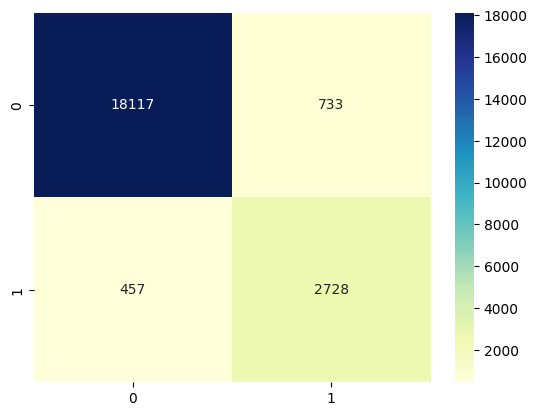

              precision    recall  f1-score   support

           0    0.97540   0.96111   0.96820     18850
           1    0.78821   0.85651   0.82094      3185

    accuracy                        0.94600     22035
   macro avg    0.88180   0.90881   0.89457     22035
weighted avg    0.94834   0.94600   0.94692     22035

0.8945735762265331
0.9088144860066042


In [9]:
valid_predictions(y_test, preds)

In [7]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.8808838139079702
0.9227716126238293


In [8]:
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.8808838139079702
0.9227716126238293


In [79]:
save_submission(pipeline, 'submission_cat')

In [100]:
preds_cat = pd.DataFrame(preds)

In [101]:
%store -r preds_lgbm
preds_lgbm = pd.DataFrame(preds_lgbm)

In [102]:
res_df = pd.concat([preds_cat, preds_lgbm], axis=1)

In [103]:
res_df

,0,0
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
22495,0,0
22496,0,0
22497,0,0
22498,0,0


In [104]:
res_df['equal'] = [1 if x == y else 0 for x, y in zip(res_df.iloc[:, 0].values, res_df.iloc[:, 1].values)]

In [105]:
res_df['equal'].value_counts()

equal
1    21909
0      591
Name: count, dtype: int64

In [9]:
preds = pipeline.predict(X_test)
print(f1_score(y_test, preds, average='macro'))
print(roc_auc_score(y_test, preds))

0.8923816188804096
0.8822463824705095
